In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from torchvision import models, transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
print("CUDA Available:", torch.cuda.is_available())
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

CUDA Available: True
Device Name: NVIDIA GeForce RTX 3080


In [3]:
def load_and_split_data(x_path, t_path, test_size=0.2, random_state=42):
    # Load the data
    x = pd.read_csv(x_path, header=None).values.astype(np.float32)
    t = pd.read_csv(t_path, header=None).values.flatten().astype(np.int64)
    
    # Split into training and testing sets
    x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=test_size, random_state=random_state)
    return x_train, x_test, t_train, t_test

In [4]:
class GreekLettersDataset(Dataset):
    def __init__(self, x, t, transform=None):
        """
        Initialize the dataset with NumPy arrays instead of file paths.
        """
        self.x = x
        self.t = t
        self.transform = transform

    def __len__(self):
        return len(self.t)

    def __getitem__(self, idx):
        # Ensure the data is reshaped correctly
        img = self.x[idx].reshape(100, 100).astype(np.float32)
        img = np.stack([img] * 3, axis=0)  # Convert to 3 channels
        if self.transform:
            img = self.transform(torch.tensor(img))
        else:
            img = torch.tensor(img, dtype=torch.float32) / 255.0
        label = self.t[idx]
        return img, label

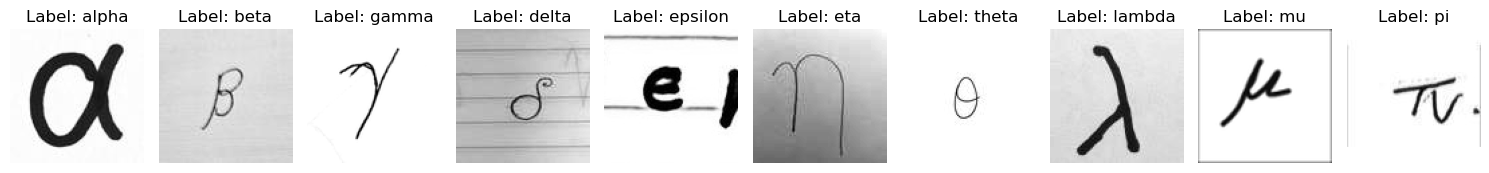

In [ ]:
def visualize_dataset(x_path, t_path, num_images=5):
    # Mapping from integer labels to Greek letter names
    label_to_letter = {
        0: "alpha",
        1: "beta",
        2: "gamma",
        3: "delta",
        4: "epsilon",
        5: "eta",
        6: "theta",
        7: "lambda",
        8: "mu",
        9: "pi"
    }

    # Load the data
    x = pd.read_csv(x_path, header=None).values.astype(np.float32)
    t = pd.read_csv(t_path, header=None).values.flatten().astype(np.int64)

    # Create the dataset
    dataset = GreekLettersDataset(x, t)
    total_samples = len(dataset)

    # Select evenly spaced indices
    step = max(1, total_samples // num_images)  # Calculate step size
    selected_indices = list(range(0, total_samples, step))[:num_images]

    # Create a figure to display the images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, idx in enumerate(selected_indices):
        img, label = dataset[idx]
        img = img.numpy().transpose(1, 2, 0)[:, :, 0]  # Convert to grayscale
        letter = label_to_letter[label]  # Map label to Greek letter
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Label: {letter}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()
    
# Call the function to visualize
visualize_dataset('../data/x_train_project.csv', '../data/t_train_project.csv', num_images=10)

In [6]:
def train():
    # Load and split the data
    x_train, x_test, t_train, t_test = load_and_split_data('../data/x_train_project.csv', '../data/t_train_project.csv')
    
        # Save the test split to CSV files
    pd.DataFrame(x_test).to_csv('../data/x_test_split.csv', header=False, index=False)
    pd.DataFrame(t_test).to_csv('../data/t_test_split.csv', header=False, index=False)

    # Define the data transformation
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Normalize([0.5] * 3, [0.5] * 3)
    ])

    # Create datasets and dataloaders
    train_dataset = GreekLettersDataset(x_train, t_train, transform=transform)
    test_dataset = GreekLettersDataset(x_test, t_test, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Load the ResNet18 model
    model = models.resnet18()
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 10)  # Update the final layer for 10 classes

    # Print model architecture
    print("Model Architecture:")
    print(model)

    # Set the device (CPU or GPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\nTraining on device: {device}")
    model = model.to(device)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Training loop
    print("\nStarting Training...\n")
    model.train()
    for epoch in range(10):
        running_loss = 0.0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Print epoch summary
        print(f"Epoch {epoch+1}/{10} - Loss: {running_loss/len(train_loader):.4f}")

    # Save the trained model
    torch.save(model.state_dict(), 'greek_model.pt')
    print("\nTraining Complete. Model saved as 'greek_model.pt'.")
    return model

In [7]:
model = train()

Model Architecture:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): R